In [3]:
n = 5
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]

In [4]:
from qiskit.quantum_info import SparsePauliOp
def build_hamiltonian(n, edge_list):
    pauli_list = []
    for (i, j, weight) in edge_list:
        pauli_list.append(["I"] * n)
        pauli_list[-1][i] = "Z"
        pauli_list[-1][j] = "Z"
        pauli_list[-1] = ("".join(pauli_list[-1])[::-1], weight)
    return SparsePauliOp.from_list(pauli_list)

In [5]:
print("Cost Function Hamiltonian:", build_hamiltonian(n, edge_list))

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


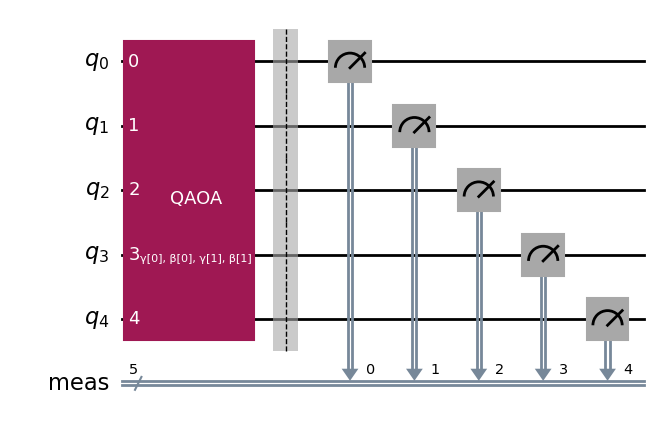

In [6]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=build_hamiltonian(n, edge_list), reps=2)
circuit.measure_all()

circuit.draw('mpl')

In [7]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

AerSimulator('aer_simulator')


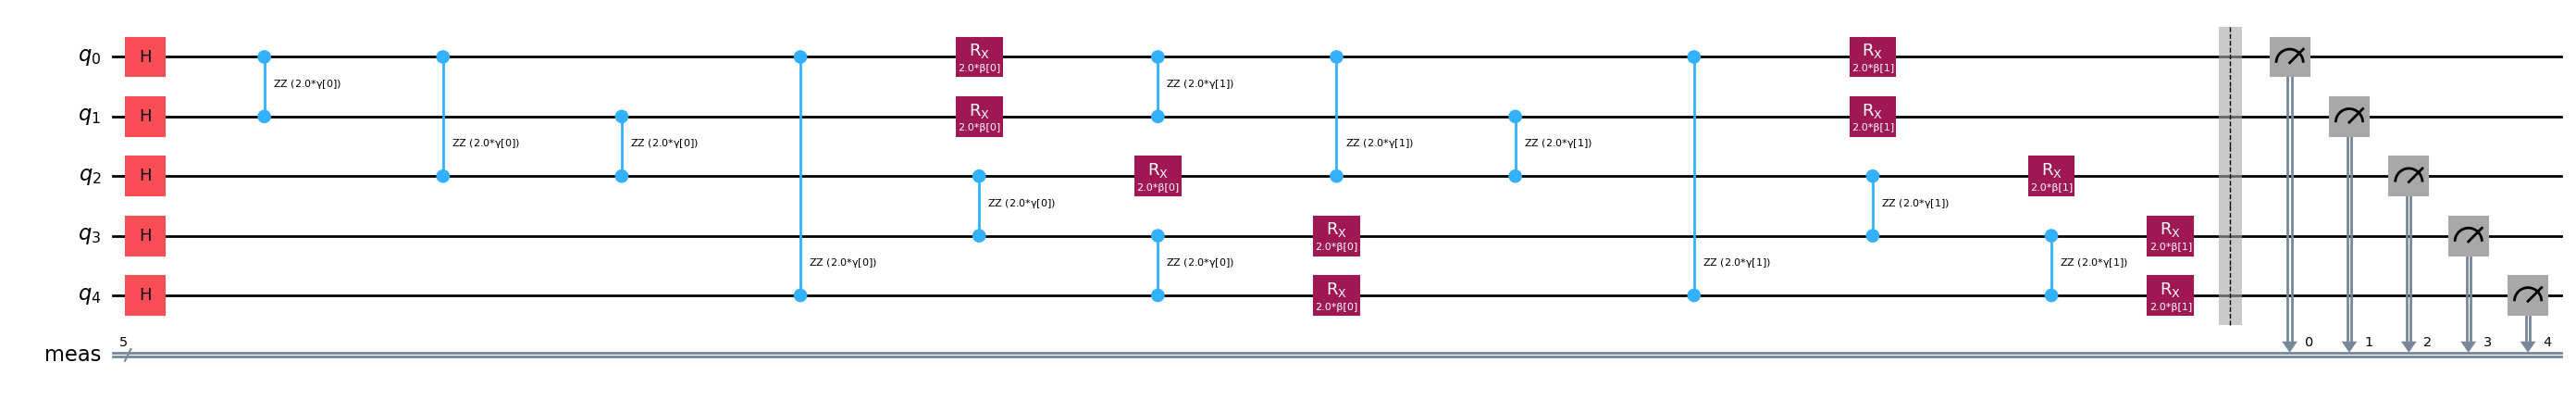

In [8]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator


# 使用 AerSimulator 作为本地后端
backend = AerSimulator()

# QiskitRuntimeService.save_account(channel="ibm_quantum", token="", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum')
# backend = service.least_busy(min_num_qubits=127)
print(backend)
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)
candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [9]:
import numpy as np
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

In [10]:
objective_func_vals = []
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    objective_func_vals.append(cost)
    print("{}th iteration's cost: {}", len(objective_func_vals), objective_func_vals[-1])
    return cost

In [12]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize
objective_func_vals = []
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    # estimator = Estimator(mode=session)
    # estimator.options.default_shots = 1000
    # # Set simple error suppression/mitigation options
    # estimator.options.dynamical_decoupling.enable = True
    # estimator.options.dynamical_decoupling.sequence_type = "XY4"
    # estimator.options.twirling.enable_gates = True
    # estimator.options.twirling.num_randomizations = "auto"
    estimator = Estimator()
    estimator.options.default_shots = 1000
    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, build_hamiltonian(n, edge_list), estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

{}th iteration's cost: {} 1 0.0839160839160839
{}th iteration's cost: {} 2 -0.01998001998001998
{}th iteration's cost: {} 3 0.09190809190809192
{}th iteration's cost: {} 4 0.11588411588411596
{}th iteration's cost: {} 5 0.039960039960039974
{}th iteration's cost: {} 6 -0.09190809190809192
{}th iteration's cost: {} 7 -1.3866133866133867
{}th iteration's cost: {} 8 2.0079920079920077
{}th iteration's cost: {} 9 -0.0959040959040959
{}th iteration's cost: {} 10 -1.6203796203796204
{}th iteration's cost: {} 11 -2.7992007992007992
{}th iteration's cost: {} 12 1.6463536463536461
{}th iteration's cost: {} 13 -1.6183816183816184
{}th iteration's cost: {} 14 0.00399600399600399
{}th iteration's cost: {} 15 -0.20379620379620378
{}th iteration's cost: {} 16 1.9980019980019983
{}th iteration's cost: {} 17 -0.5554445554445555
{}th iteration's cost: {} 18 -2.4735264735264737
{}th iteration's cost: {} 19 -2.767232767232767
{}th iteration's cost: {} 20 -2.5614385614385617
{}th iteration's cost: {} 21 -

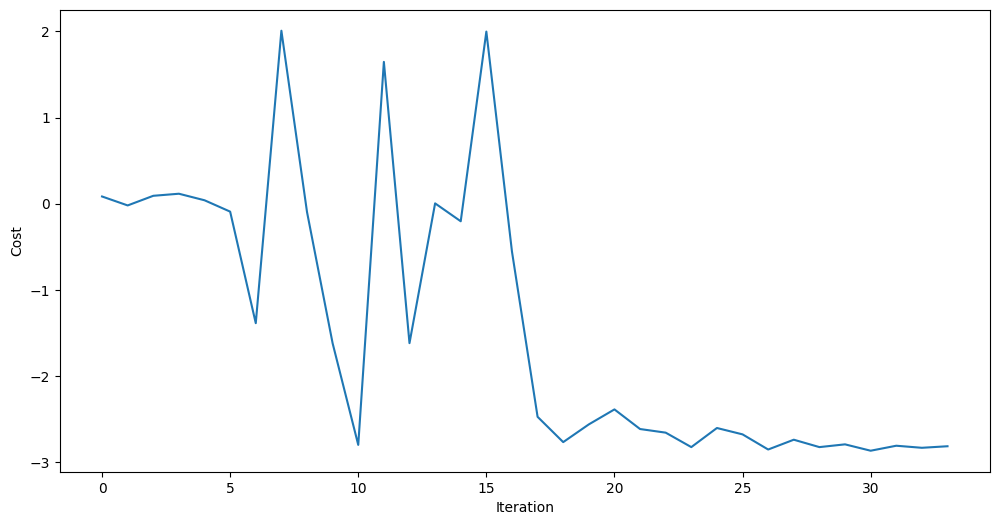

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

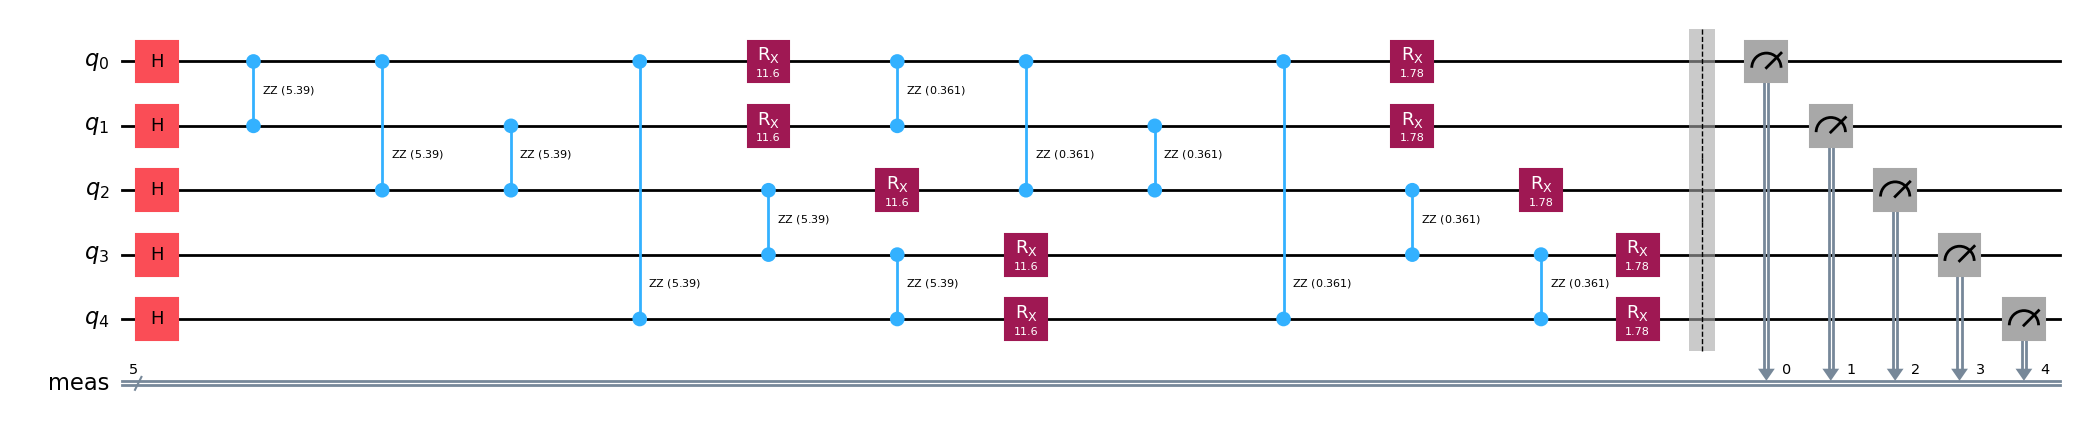

In [14]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [15]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000
# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"
pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{20: 0.1536, 11: 0.1543, 13: 0.0421, 9: 0.1486, 22: 0.1466, 12: 0.0075, 26: 0.0575, 19: 0.0084, 10: 0.0402, 18: 0.0403, 16: 0.0114, 8: 0.0141, 14: 0.0072, 5: 0.0626, 21: 0.0385, 24: 0.0074, 15: 0.0126, 7: 0.0065, 17: 0.0078, 31: 0.003, 0: 0.0027, 23: 0.0137, 2: 0.0038, 25: 0.0015, 6: 0.0015, 29: 0.0031, 3: 0.0014, 4: 0.0004, 28: 0.0011, 1: 0.0004, 27: 0.0001, 30: 0.0001}


/home/hyjing/Code/Quantum_Algorithm/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:268: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [16]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]
keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(edge_list))
most_likely_bitstring.reverse()
print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 1, 0, 1, 0, 0]


/tmp/ipykernel_40883/2224453897.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


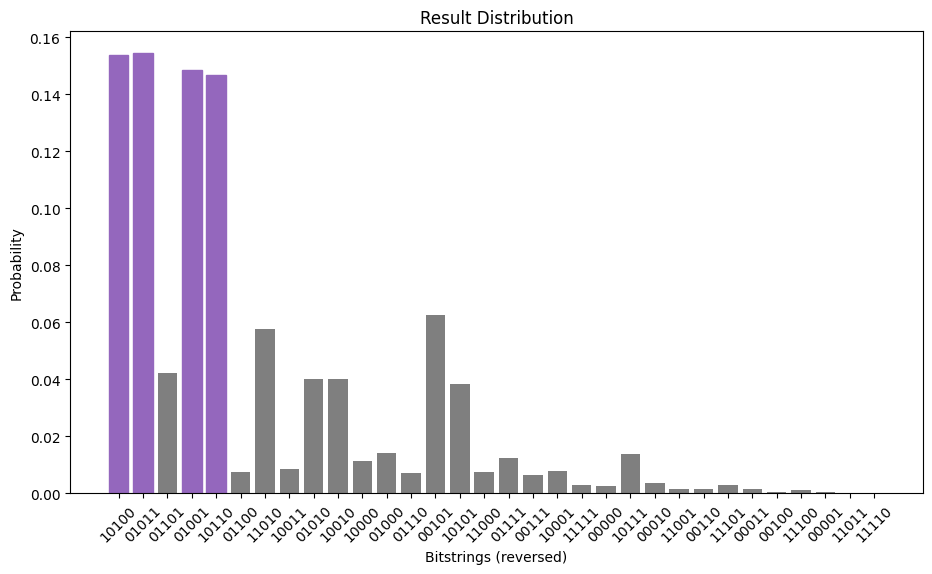

In [17]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()